# <center> Практика: Подбор гиперпараметров моделей </center>

In [1]:
# необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import hyperopt
import optuna
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model #линейные модели
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials

%matplotlib inline
plt.style.use('seaborn')

## Чтение данных

In [2]:
# загружаем данные и выводим несколько строк
data = pd.read_csv('data/train_sem.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# посмотрим на размер таблицы
data.shape

(3751, 1777)

Создаем матрицу наблюдений $X$ и вектор правильных ответов $y$

In [4]:
# матрица наблюдений X и вектор правильных ответов y
X = data.drop('Activity', axis=1)
y = data['Activity']

1    0.542255
0    0.457745
Name: Activity, dtype: float64

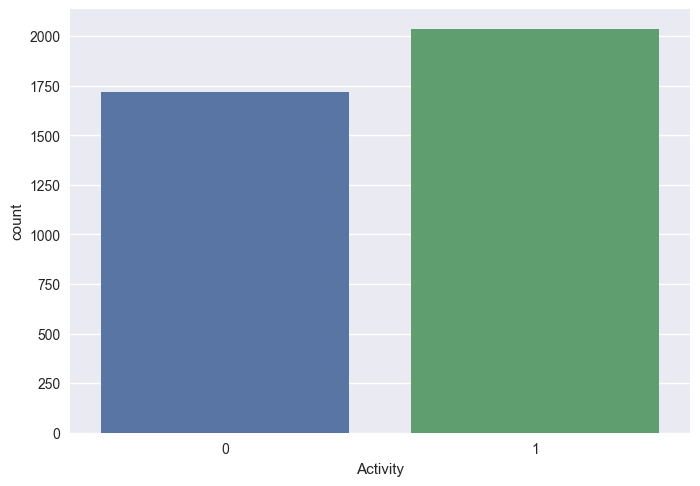

In [5]:
# оценим сбалансированность классов в целевом признаке
display(y.value_counts(True))
sns.countplot(data=data, x='Activity');

Классы имеют небольшой дисбаланс, выполним двухкомпонентное разбиение выборки со стратификацией в соотношении 70/30

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### **Модель логистической регрессии с параметрами по умолчанию**
Решим задачу бинарной классификации с помощью логистической регрессии с параметрами по умолчанию

In [7]:
# зафиксируем random_state
random_state = 42
# для подведения итогов и построения визализации создадим списки:
# список наименований этапов подбора параметров модели
types = ['Hold-out', 'K-fold', 'GSCV', 'RSCV', 'Hyperopt', 'Optuna']
# пустые списки для заполнения значениями метрик f1
logreg_f1 = []
randomforest_f1 = []

In [8]:
#Создаем модель
log_reg = linear_model.LogisticRegression(random_state=random_state, max_iter=500)
# обучаем модель
log_reg.fit(X_train, y_train)
# выполним предсказание
y_pred_lr = log_reg.predict(X_test)
# рассчитаем метрику F1-score
f1_hold_out = metrics.f1_score(y_test, y_pred_lr).round(3)
print('LogReg hold-out F1-score:', f1_hold_out)
# добавляем метрику в список
logreg_f1.append(f1_hold_out)

LogReg hold-out F1-score: 0.78


In [9]:
#Создаём объект кросс-валидатора StratifiedKFold
skf = model_selection.StratifiedKFold(n_splits=5)
#Считаем метрику на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=log_reg, #модель 
    X=X, #матрица наблюдений X 
    y=y, #вектор ответов y 
    cv=skf, #кросс-валидатор 
    scoring='f1' #метрика 
    )
display(cv_metrics)
f1_k_fold = np.mean(cv_metrics['test_score']).round(3)
print('LogReg k-fold mean F1-score:', f1_k_fold)
# добавляем метрику в список
logreg_f1.append(f1_k_fold)

{'fit_time': array([3.04539633, 3.13121605, 2.88331032, 2.94599032, 2.92546105]),
 'score_time': array([0.01561117, 0.02415848, 0.02534819, 0.02597332, 0.02449179]),
 'test_score': array([0.76108374, 0.78953627, 0.76271186, 0.79081016, 0.77546012])}

LogReg k-fold mean F1-score: 0.776


### <center> **Подбор гиперпараметров для логистической регрессии**

#### <center> **GridSearchCV** для логистической регрессии

In [10]:
# задаем гиперпараметры
param_grid = {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
              'C': list(np.linspace(0.05, 0.15, 5, dtype=float)) # уровень силы регуляризации
              }

grid_search = GridSearchCV(
    estimator=log_reg, # модель
    param_grid=param_grid, # словарь гиперпараметров
    cv=5, # количество фолдов в кросс-валидации
    n_jobs = -1
)
  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
# расчет метрики на тестовой выборке
f1_gscv = metrics.f1_score(y_test, y_test_pred).round(3)
print('LogReg GSCV F1-score:', f1_gscv)
# добавляем метрику в список
logreg_f1.append(f1_gscv)

CPU times: total: 2.84 s
Wall time: 7min
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg GSCV F1-score: 0.79


#### <center> **RandomizedSearchCV** для логистической регрессии

In [11]:
# задаем гиперпараметры
param_distributions = {'penalty': ['l2', 'none'], # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
              'C': list(np.linspace(0.05, 0.15, 5, dtype=float)) # уровень силы регуляризации
              }
random_search = RandomizedSearchCV(
    estimator=log_reg, # модель
    param_distributions=param_distributions, # словарь гиперпараметров
    cv=5, # количество фолдов в кросс-валидации
    n_jobs = -1,
    n_iter = 15, # количество комбинаций гиперпараметров
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
# расчет метрики
f1_rscv = metrics.f1_score(y_test, y_test_pred).round(3)
print('LogReg GSCV F1-score:', f1_rscv)
# добавляем метрику в список
logreg_f1.append(f1_rscv)

CPU times: total: 2.78 s
Wall time: 4min 39s
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.05}
LogReg GSCV F1-score: 0.79


#### <center> **Hyperopt** для логистической регрессии

In [12]:
# зададим пространство поиска гиперпараметров
space = {
    'penalty': hp.choice(label='penalty', options=['l2', 'none']),
    'solver': hp.choice(label='solver', options=['lbfgs', 'sag']),
    'C': hp.uniform(label='C', low=0.05, high=0.15)
}

In [13]:
# создаем функцию для минимизации 
def hyperopt_logreg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    # обучаем модель
    model.fit(X, y) 
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо максимизировать, поэтому ставим знак минус
    return -score 

In [14]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(
    fn=hyperopt_logreg, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации
    max_evals=30, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
    )

best_space = hyperopt.space_eval(space, best)
print("Наилучшие значения гиперпараметров {}".format(best_space))

100%|██████████| 30/30 [06:11<00:00, 12.39s/trial, best loss: -0.7923984745121717]
Наилучшие значения гиперпараметров {'C': 0.06325261922632554, 'penalty': 'l2', 'solver': 'sag'}
CPU times: total: 2min 20s
Wall time: 6min 13s


In [15]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=best_space['penalty'],
    solver=best_space['solver'],
    C=best_space['C']
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
f1_hyperopt = metrics.f1_score(y_test, y_test_pred).round(3)
print('LogReg Hyperopt F1-score:', f1_hyperopt)
# добавляем метрику в список
logreg_f1.append(f1_hyperopt)

LogReg Hyperopt F1-score: 0.79


#### <center> **Optuna** для логистической регрессии

In [16]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 0.15)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=skf, scoring="f1", n_jobs=-1).mean()

  return score  

In [17]:
%%time
# cоздаем объект исследования
# указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=30)

[I 2023-03-16 14:35:58,660] A new study created in memory with name: LogisticRegression
[I 2023-03-16 14:36:18,348] Trial 0 finished with value: 0.7673902574095766 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.13794125916313765}. Best is trial 0 with value: 0.7673902574095766.
[I 2023-03-16 14:36:22,035] Trial 1 finished with value: 0.7382304069684554 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01945344447153609}. Best is trial 0 with value: 0.7673902574095766.
[I 2023-03-16 14:36:40,810] Trial 2 finished with value: 0.7911300263841337 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.049645090103915386}. Best is trial 2 with value: 0.7911300263841337.
[I 2023-03-16 14:36:59,313] Trial 3 finished with value: 0.7673902574095766 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.0585819275247641}. Best is trial 2 with value: 0.7911300263841337.
[I 2023-03-16 14:37:18,239] Trial 4 finished with value: 0.7673902574095766 and parameters: {'pe

CPU times: total: 1min 54s
Wall time: 4min 49s


In [18]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем метрику для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
f1_optuna = metrics.f1_score(y_test, y_test_pred).round(3)
print("LogReg Optuna F1-score:", f1_optuna)
# добавляем метрику в список
logreg_f1.append(f1_optuna)

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.06521294515278883}
LogReg Optuna F1-score: 0.79


### **Модель случайного леса с параметрами по умолчанию**
Решим задачу бинарной классификации с помощью случайного леса с параметрами по умолчанию

In [19]:
# Создаем модель
rf = ensemble.RandomForestClassifier(random_state = random_state)
# обучаем модель
rf.fit(X_train, y_train)
# предсказание
y_pred_rf = rf.predict(X_test)
# расчет метрики
f1_hold_out = metrics.f1_score(y_test, y_pred_rf).round(3)
print('Random Forest hold-out F1-score:', f1_hold_out)
# добавляем метрику в список
randomforest_f1.append(f1_hold_out)

Random Forest hold-out F1-score: 0.793


In [20]:
#Считаем метрику на кросс-валидации k-fold
cv_metrics_rf = model_selection.cross_validate(
    estimator=rf, #модель 
    X=X, #матрица наблюдений X 
    y=y, #вектор ответов y 
    cv=skf, #кросс-валидатор 
    scoring='f1' #метрика 
    )

f1_k_fold = np.mean(cv_metrics_rf['test_score']).round(3)
print('Random Forest k-fold mean F1-score:', f1_k_fold)
# добавляем метрику в список
randomforest_f1.append(f1_k_fold)

Random Forest k-fold mean F1-score: 0.813


#### <center> **GridSearchCV** для случайного леса

In [21]:
# задаем гиперпараметры
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(10, 25, 8, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 

y_test_pred = grid_search_forest.predict(X_test)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))
f1_gscv = metrics.f1_score(y_test, y_test_pred).round(3)
print('Random Forest GSCV F1-score:', f1_gscv)
# добавляем метрику в список
randomforest_f1.append(f1_gscv)

CPU times: total: 3.38 s
Wall time: 3min 49s
Наилучшие значения гиперпараметров: {'max_depth': 16, 'min_samples_leaf': 5, 'n_estimators': 130}
Random Forest GSCV F1-score: 0.787


#### <center> **RandomizedSearchCV** для случайного леса

In [22]:
# задаем гиперпараметры
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(10, 25, 8, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))
f1_rscv = metrics.f1_score(y_test, y_test_pred).round(3)
print('Random Forest RSCV F1-score:', f1_rscv)
# добавляем метрику в список
randomforest_f1.append(f1_rscv)

CPU times: total: 4.03 s
Wall time: 1min 32s
Наилучшие значения гиперпараметров: {'n_estimators': 190, 'min_samples_leaf': 5, 'max_depth': 16}
Random Forest RSCV F1-score: 0.791


#### <center> **Hyperopt** для случайного леса

In [23]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 250, 10),
       'max_depth' : hp.quniform('max_depth', 12, 25, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [24]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    # обучаем модель
    model.fit(X, y)
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо максимизировать, поэтому ставим знак минус
    return -score

In [25]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))
print("Наилучшие значения гиперпараметров {}".format(hyperopt.space_eval(space, best)))

100%|██████████| 30/30 [04:21<00:00,  8.73s/trial, best loss: -0.8215888642046005]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 3.0, 'n_estimators': 120.0}
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 3.0, 'n_estimators': 120.0}
CPU times: total: 1min 28s
Wall time: 4min 21s


In [26]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
f1_hyperopt = metrics.f1_score(y_test, y_test_pred).round(3)
print('Random Forest Hyperopt F1-score:', f1_hyperopt)
# добавляем значение метрики в список
randomforest_f1.append(f1_hyperopt)

Random Forest Hyperopt F1-score: 0.799


#### <center> **Optuna** для случайного леса

In [27]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 250, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  min_samples_split = trial.suggest_int('min_samples_split', 1, 3, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          criterion=criterion,
                                          min_samples_split=min_samples_split,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=skf, scoring="f1", n_jobs=-1).mean()
  # score = metrics.f1_score(y_train, model.predict(X_train))

  return score  

In [28]:
%%time
# cоздаем объект исследования
# нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-03-16 14:50:55,496] A new study created in memory with name: RandomForestClassifier
[I 2023-03-16 14:51:04,407] Trial 0 finished with value: 0.8136239773442316 and parameters: {'n_estimators': 133, 'max_depth': 19, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 2}. Best is trial 0 with value: 0.8136239773442316.
[I 2023-03-16 14:51:15,081] Trial 1 finished with value: 0.8166822551635537 and parameters: {'n_estimators': 192, 'max_depth': 21, 'min_samples_leaf': 6, 'criterion': 'entropy', 'min_samples_split': 3}. Best is trial 1 with value: 0.8166822551635537.
[I 2023-03-16 14:51:26,256] Trial 2 finished with value: 0.8194990525000853 and parameters: {'n_estimators': 184, 'max_depth': 27, 'min_samples_leaf': 4, 'criterion': 'entropy', 'min_samples_split': 1}. Best is trial 2 with value: 0.8194990525000853.
[I 2023-03-16 14:51:33,406] Trial 3 finished with value: 0.8132153804681753 and parameters: {'n_estimators': 130, 'max_depth': 21, 'min_samples_leaf': 7, '

Наилучшие значения гиперпараметров {'n_estimators': 207, 'max_depth': 28, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 1}
CPU times: total: 2min 4s
Wall time: 5min 52s


In [29]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
f1_optuna = metrics.f1_score(y_test, y_test_pred).round(3)
print('Random Forest Optuna F1-score:', f1_optuna)
# добавляем метрику в список
randomforest_f1.append(f1_optuna)

Random Forest Optuna F1-score: 0.807


In [30]:
# проверяем содержимое списков
print(types)
print(logreg_f1)
print(randomforest_f1)

['Hold-out', 'K-fold', 'GSCV', 'RSCV', 'Hyperopt', 'Optuna']
[0.78, 0.776, 0.79, 0.79, 0.79, 0.79]
[0.793, 0.813, 0.787, 0.791, 0.799, 0.807]


In [31]:
# Создаем таблицу с результатами
res_df = pd.DataFrame(
    data=zip(logreg_f1, randomforest_f1),
    columns=['LogReg F1 score', 'RandomForest F1 score'],
    index=types
    )
display(res_df)

,LogReg F1 score,RandomForest F1 score
Hold-out,0.780,0.793
K-fold,0.776,0.813
GSCV,0.790,0.787
RSCV,0.790,0.791
Hyperopt,0.790,0.799
Optuna,0.790,0.807


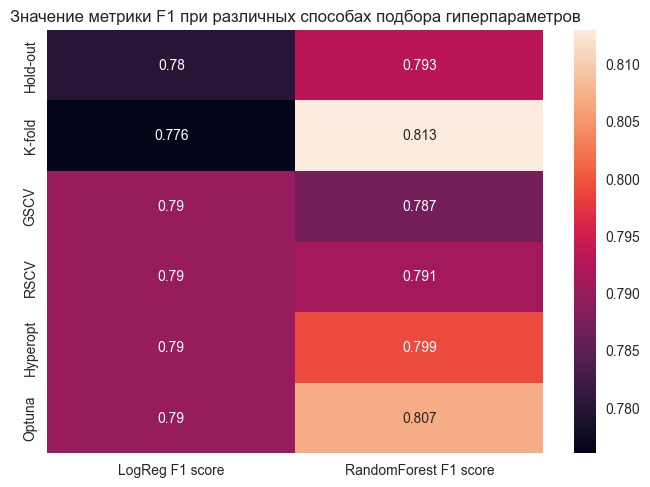

In [32]:
# построение визуализации
sns.heatmap(res_df, annot=True, fmt ='.3g')
plt.title('Значение метрики F1 при различных способах подбора гиперпараметров') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика;

Выводы. Различные способы нахождения гиперпараметров показывают похожие результаты. Разница заключается в удобстве применения и скорости их работы